# Understanding the PPO Training Workflow

This notebook breaks down the `ppo.py` script step by step to understand how the dynamic treatment allocation system works.

## Overview
- **Goal**: Learn treatment allocation policies using Proximal Policy Optimization (PPO)
- **Environment**: Dynamic job training program with budget/time constraints
- **Policy**: Decides whether to treat each arriving individual based on their covariates


### Step 1: Imports and Setup


In [2]:

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set up paths
import sys
sys.path.insert(0, 'code')

from rctenvironments.jobtraining import DynamicJTPA, load_and_merge_data
from rctenvironments import ite_estimation
import core
from utils import setup_logger_kwargs, proc_id, num_procs

print("Imports successful!")


Imports successful!


### Step 2: Load and Explore Raw Data


In [3]:
# Load raw data
input_dir = "data/input"
df_raw = load_and_merge_data(input_dir)

print(f"Dataset shape: {df_raw.shape}")
print(f"\nColumns: {df_raw.columns.tolist()}")
print(f"\nFirst few rows:")
df_raw.head()


Dataset shape: (9223, 7)

Columns: ['recid', 'date', 'age', 'allocated_trmt', 'earnings', 'prev_earnings', 'education']

First few rows:


,recid,date,age,allocated_trmt,earnings,prev_earnings,education
0,300001,1989-05-16,46.0,1,1353,0,12
1,300002,1989-08-30,24.0,1,4984,3591,11
2,300006,1988-08-18,34.0,1,27707,0,12
3,300008,1989-03-08,31.0,1,31860,9476,10
4,300010,1988-11-16,22.0,0,26615,9600,9


### Check if data is panel (multiple observations per individual)


In [4]:
# Sort by recid and date to see if there are multiple observations per individual
df_sorted = df_raw.sort_values(['recid', 'date'])

# Check number of unique individuals
print(f"Total observations: {len(df_sorted)}")
print(f"Unique individuals (recid): {df_sorted['recid'].nunique()}")

# Count observations per individual
obs_per_individual = df_sorted['recid'].value_counts()
print(f"\nObservations per individual:")
print(obs_per_individual.describe())


Total observations: 9223
Unique individuals (recid): 9223

Observations per individual:
count    9223.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: count, dtype: float64


In [5]:
df_sorted.head()

,recid,date,age,allocated_trmt,earnings,prev_earnings,education
0,300001,1989-05-16,46.0,1,1353,0,12
1,300002,1989-08-30,24.0,1,4984,3591,11
2,300006,1988-08-18,34.0,1,27707,0,12
3,300008,1989-03-08,31.0,1,31860,9476,10
4,300010,1988-11-16,22.0,0,26615,9600,9


### Step 3: Understand ITE (Individual Treatment Effect) Estimation

ITEs are estimates of how much each individual would benefit from treatment. These serve as rewards in the RL environment.


Treatment distribution:
allocated_trmt
1    6133
0    3090
Name: count, dtype: int64

Treatment rate: 66.50%

Earnings by treatment status:
                 count          mean           std  min      25%      50%  \
allocated_trmt                                                              
0               3090.0  15310.520065  16392.320602  0.0  1722.25  10472.0   
1               6133.0  16487.492744  17390.606309  0.0  2115.00  11505.0   

                     75%       max  
allocated_trmt                      
0               24150.75  108542.0  
1               25689.00  155760.0  


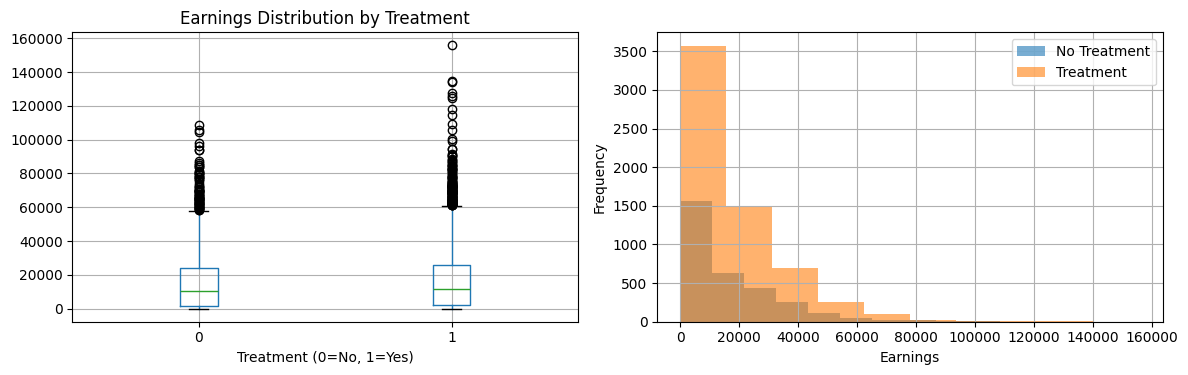

In [6]:
# Show treatment assignment and outcomes
print("Treatment distribution:")
print(df_raw['allocated_trmt'].value_counts())
print(f"\nTreatment rate: {df_raw['allocated_trmt'].mean():.2%}")

print("\nEarnings by treatment status:")
print(df_raw.groupby('allocated_trmt')['earnings'].describe())

# Visualize earnings distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df_raw.boxplot(column='earnings', by='allocated_trmt', ax=axes[0])
axes[0].set_title('Earnings Distribution by Treatment')
axes[0].set_xlabel('Treatment (0=No, 1=Yes)')
plt.suptitle('')

# Histogram
df_raw[df_raw['allocated_trmt']==0]['earnings'].hist(alpha=0.6, label='No Treatment', ax=axes[1])
df_raw[df_raw['allocated_trmt']==1]['earnings'].hist(alpha=0.6, label='Treatment', ax=axes[1])
axes[1].legend()
axes[1].set_xlabel('Earnings')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [7]:
# Estimate ITEs using doubly robust method (as done in the environment)
df_with_ites = ite_estimation.add_doubly_robust_ites(
    df=df_raw.copy(),
    outcome='earnings',
    treatment_indicator='allocated_trmt',
    covariates=['age', 'education', 'prev_earnings']
)


In [8]:
print("ITE statistics:")
print(df_with_ites['ite'].describe())

# Show examples of ITEs for treated and untreated individuals
print("\nExample of ITEs for treated individuals:")
print(df_with_ites[df_with_ites['allocated_trmt']==1][['recid', 'allocated_trmt', 'earnings', 'ite']].head(5))

print("\nExample of ITEs for untreated individuals:")
print(df_with_ites[df_with_ites['allocated_trmt']==0][['recid', 'allocated_trmt', 'earnings', 'ite']].head(5))

ITE statistics:
count      9223.000000
mean       1226.012060
std       32939.044392
min     -274426.381977
25%      -16224.201606
50%       -1403.247665
75%       22356.831961
max      185387.692127
Name: ite, dtype: float64

Example of ITEs for treated individuals:
    recid  allocated_trmt  earnings           ite
0  300001               1      1353 -14046.497684
1  300002               1      4984 -17100.981891
2  300006               1     27707  24092.243835
3  300008               1     31860  13831.646640
5  300012               1     48541  53530.655348

Example of ITEs for untreated individuals:
     recid  allocated_trmt  earnings           ite
4   300010               0     26615 -11915.210744
12  300025               0     19541 -27182.903671
15  300028               0     25199 -17637.492098
16  300030               0     24765  -8400.812688
18  300033               0     18888  28919.893662


### Step 4: Initialize the RL Environment


In [10]:
# Create environment (similar to what happens in ppo.py)
env = DynamicJTPA(
    input_dir="data/input",
    output_dir="data/output/environment",
    non_stationary_policy=False,  # Stationary policy (only uses covariates)
    logistic_policy=True,  # Use logistic/sigmoid policy
    normalise_z_t=True,  # Normalize budget and time
    discount_factor=1.0,
    kt_rewards=False,  # Use our own ITE estimates
    individual_specific_costs=True,
    monthly_arrival_rates=True,
    start_month=0,
    write_processed_env_data_to_disk=True  # Save processed data for inspection
)

Estimating doubly robust ITEs


In [11]:
print("Environment created successfully!")
print(f"\nEnvironment dimensions:")
print(f"  - Number of covariates: {env.num_covariates}")
print(f"  - Policy states: {env.num_policy_states}")
print(f"  - Value states: {env.num_value_states}")
print(f"  - Buffer states: {env.num_buffer_states}")
print(f"  - Number of actions: {env.num_actions}")

Environment created successfully!

Environment dimensions:
  - Number of covariates: 3
  - Policy states: 3
  - Value states: 5
  - Buffer states: 5
  - Number of actions: 2


In [12]:
# Inspect the processed environment data
print("Processed environment data shape:", env.df.shape)
print("\nColumns in processed data:", env.df.columns.tolist())
print("\nFirst few rows of processed data:")
env.df.head()


Processed environment data shape: (9223, 20)

Columns in processed data: ['recid', 'date', 'age', 'allocated_trmt', 'earnings', 'prev_earnings', 'education', 'y0hat', 'y1hat', 'ite', 'ite_ols', 'reward', 'reward_scaled', 'year', 'month', 'cost', 'cost_scaled', 'age_scaled', 'education_scaled', 'prev_earnings_scaled']

First few rows of processed data:


,recid,date,age,allocated_trmt,earnings,prev_earnings,education,y0hat,y1hat,ite,ite_ols,reward,reward_scaled,year,month,cost,cost_scaled,age_scaled,education_scaled,prev_earnings_scaled
0,300001,1989-05-16,46.0,1,1353,0,12,10501.320485,11074.851378,-14046.497684,573.530893,-14820.497684,-0.449961,1989,5,1257.0,0.000725,1.327606,0.207613,-0.758122
1,300002,1989-08-30,24.0,1,4984,3591,11,15799.248554,17459.858432,-17100.981891,1660.609878,-17874.981891,-0.542698,1989,8,1257.0,0.000725,-0.952930,-0.326505,0.084063
2,300006,1988-08-18,34.0,1,27707,0,12,11387.031017,12280.669362,24092.243835,893.638345,23318.243835,0.707959,1988,8,1257.0,0.000725,0.083677,0.207613,-0.758122
3,300008,1989-03-08,31.0,1,31860,9476,10,21962.344588,24051.854950,13831.646640,2089.510362,13057.646640,0.396440,1989,3,1895.2,0.001092,-0.227305,-0.860622,1.464251
4,300010,1988-11-16,22.0,0,26615,9600,9,21746.762626,24362.216380,-11915.210744,2615.453754,-12689.210744,-0.385254,1988,11,1920.0,0.001107,-1.160251,-1.394739,1.493332


In [13]:
# Inspect environment parameters
print("Environment Configuration:")
print(f"  Initial budget (Z): {env.Z}")
print(f"  Time horizon (T): {env.T}")
print(f"  Discount factor: {env.discount_factor}")
print(f"  Budget sufficient to treat fraction of yearly arrivals: {env.budget_sufficient_to_treat_fraction_of_yearly_arrivals}")

print(f"\nArrival Rates:")
if env.monthly_arrival_rates:
    print("  Monthly arrivals:")
    for i, arrivals in enumerate(env.monthly_arrivals):
        print(f"    Month {i+1}: {arrivals:.2f}")
    print(f"  Combined yearly arrivals: {env.combined_yearly_arrivals:.2f}")
else:
    print(f"  Constant arrival rate (delta_time): {env.constant_delta_time:.6f}")

print(f"\nCosts:")
if env.individual_specific_costs:
    print(f"  Individual-specific costs enabled")
    print(f"  Average costs by month:")
    for i, cost in enumerate(env.average_individual_costs_by_month):
        print(f"    Month {i+1}: {cost:.4f}")
    print(f"  Combined costs of yearly arrivals: {env.combined_costs_of_yearly_arrivals:.4f}")
else:
    print(f"  Constant costs")


Environment Configuration:
  Initial budget (Z): 1
  Time horizon (T): 1.0
  Discount factor: 1.0
  Budget sufficient to treat fraction of yearly arrivals: 0.25

Arrival Rates:
  Monthly arrivals:
    Month 1: 468.00
    Month 2: 469.50
    Month 3: 493.50
    Month 4: 355.50
    Month 5: 321.50
    Month 6: 295.00
    Month 7: 330.00
    Month 8: 411.50
    Month 9: 421.00
    Month 10: 685.00
    Month 11: 280.50
    Month 12: 423.00
  Combined yearly arrivals: 4954.00

Costs:
  Individual-specific costs enabled
  Average costs by month:
    Month 1: 1386.3165
    Month 2: 1410.9894
    Month 3: 1416.9078
    Month 4: 1422.4045
    Month 5: 1411.0544
    Month 6: 1465.6990
    Month 7: 1434.8952
    Month 8: 1392.7125
    Month 9: 1402.9019
    Month 10: 1346.0526
    Month 11: 1353.4599
    Month 12: 1414.0317
  Combined costs of yearly arrivals: 6939264.8000


### Step 5: Interact with the Environment (Single Episode)


In [14]:
# Reset environment and observe initial state
initial_state = env.reset()

print("Initial State:")
print(f"  Shape: {initial_state.shape}")
print(f"  Values: {initial_state}")
print(f"  Components: covariates + budget + time")
print(f"\nInterpretation:")
print(f"  Covariates (first {env.num_covariates} values): {initial_state[:env.num_covariates]}")
print(f"  Budget (z): {initial_state[env.num_covariates]:.4f} (normalized from {env.z:.4f})")
print(f"  Time (t): {initial_state[env.num_covariates+1]:.4f} (normalized from {env.t:.4f})")
print(f"\nCurrent budget (actual): {env.z}")
print(f"Current time (actual): {env.t}")


Initial State:
  Shape: (5,)
  Values: [ 0.18733783  0.20761252 -0.38287951  0.5        -0.49999914]
  Components: covariates + budget + time

Interpretation:
  Covariates (first 3 values): [ 0.18733783  0.20761252 -0.38287951]
  Budget (z): 0.5000 (normalized from 1.0000)
  Time (t): -0.5000 (normalized from 0.0000)

Current budget (actual): 1
Current time (actual): 8.572723737315402e-07


In [16]:
# Simulate a few steps of interaction
print("Simulating first 10 steps of an episode...")

for step in range(10):
    print(f"--- Step {step+1} ---")
    print(f"Budget remaining: {env.z:.4f}")
    print(f"Time elapsed: {env.t:.4f}")
    
    # Random policy (will replace with trained policy later)
    action = np.random.choice([0, 1])  # 0=don't treat, 1=treat
    action_str = 'Treat' if action==1 else "Don't treat"
    print(f"Action chosen: {action} ({action_str})")
    
    # Take step
    next_state, reward, done = env.step(action)
    print(f"Reward received: {reward:.4f}")
    print(f"Episode done: {done}")
    print("")
    
    if done:
        print("Episode ended early!")
        break


Simulating first 10 steps of an episode...
--- Step 1 ---
Budget remaining: 0.9978
Time elapsed: 0.0012
Action chosen: 1 (Treat)
Reward received: 1.0260
Episode done: False

--- Step 2 ---
Budget remaining: 0.9968
Time elapsed: 0.0013
Action chosen: 0 (Don't treat)
Reward received: 0.0000
Episode done: False

--- Step 3 ---
Budget remaining: 0.9968
Time elapsed: 0.0015
Action chosen: 0 (Don't treat)
Reward received: 0.0000
Episode done: False

--- Step 4 ---
Budget remaining: 0.9968
Time elapsed: 0.0017
Action chosen: 1 (Treat)
Reward received: -0.2855
Episode done: False

--- Step 5 ---
Budget remaining: 0.9961
Time elapsed: 0.0018
Action chosen: 0 (Don't treat)
Reward received: 0.0000
Episode done: False

--- Step 6 ---
Budget remaining: 0.9961
Time elapsed: 0.0019
Action chosen: 1 (Treat)
Reward received: -0.2176
Episode done: False

--- Step 7 ---
Budget remaining: 0.9953
Time elapsed: 0.0020
Action chosen: 1 (Treat)
Reward received: 0.2316
Episode done: False

--- Step 8 ---
Budge

### Step 6: Create the Policy and Value Networks


In [17]:
# Re-initialize environment for this step
env = DynamicJTPA(
    input_dir="data/input",
    output_dir="data/output/environment",
    non_stationary_policy=False,
    logistic_policy=True,
    normalise_z_t=True,
    discount_factor=1.0,
    kt_rewards=False,
    individual_specific_costs=True,
    monthly_arrival_rates=True,
    start_month=0,
)

# Create Actor-Critic network (like in ppo.py)
ac = core.ActorCritic(
    num_policy_states=env.num_policy_states,
    num_value_states=env.num_value_states,
    num_actions=env.num_actions,
    non_stationary_policy=env.non_stationary_policy,
    logistic_policy=env.logistic_policy,
    hidden_sizes=[64, 64],  # 2 hidden layers with 64 neurons each
    activation=torch.nn.Tanh,
)

print("Actor-Critic network created!")
print(f"\nPolicy type: {'Logistic' if env.logistic_policy else 'MLP'}")
print(f"Non-stationary: {env.non_stationary_policy}")
print(f"\nNetwork parameters:")
var_counts = tuple(core.count_vars(module) for module in [ac.pi, ac.v])
print(f"  Policy (pi) parameters: {var_counts[0]:,}")
print(f"  Value function (v) parameters: {var_counts[1]:,}")
print(f"  Total parameters: {sum(var_counts):,}")


Estimating doubly robust ITEs


In [18]:
print("Actor-Critic network created!")
print(f"\nPolicy type: {'Logistic' if env.logistic_policy else 'MLP'}")
print(f"Non-stationary: {env.non_stationary_policy}")
print(f"\nNetwork parameters:")
var_counts = tuple(core.count_vars(module) for module in [ac.pi, ac.v])
print(f"  Policy (pi) parameters: {var_counts[0]:,}")
print(f"  Value function (v) parameters: {var_counts[1]:,}")
print(f"  Total parameters: {sum(var_counts):,}")

Actor-Critic network created!

Policy type: Logistic
Non-stationary: False

Network parameters:
  Policy (pi) parameters: 4
  Value function (v) parameters: 4,609
  Total parameters: 4,613
